In [112]:
# Import libraries
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.22f' % x)
import numpy as np
import matplotlib.pyplot as plt
import os
import scienceplots
plt.style.use(['science', 'ieee'])
# creates figs directory|
output_dir = 'figs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [113]:
# Read CSV data (change paths accordingly)
ads_data = pd.read_csv('../../core_1/post_layout_sim/schematic/csv/ads_data/data_MPA_export.csv', delimiter=';', comment='#')


In [114]:

# Define the path to the file
file_path = '../../core_1/post_layout_sim/schematic/csv/ads_data/data_MPA_export.csv'

# Load the data
data = pd.read_csv(file_path, header=None)
data = data.drop(0, axis=0).reset_index(drop=True)

data.columns = ['PindBm', 'PindBm_2', 'Vout_raw', 'Vin_raw', 'Po_raw', 'Iout_raw', 'Iin_raw', 'PindBm_3']

# Remove the PindBm_2 and PindBm_3 columns
data = data.drop(['PindBm_2', 'PindBm_3'], axis=1)

# Function to split magnitude and phase
def split_magnitude_phase(column):
    magnitude = []
    phase = []
    
    for value in column:
        if ' / ' in str(value):  # If it contains ' / ' (magnitude and phase)
            mag, ph = str(value).split(' / ')
            magnitude.append(float(mag))
            phase.append(float(ph))
        else:  # If it only contains magnitude (no phase)
            magnitude.append(float(value))
            phase.append(None)  # Set phase as NaN or None

    return pd.Series([magnitude, phase])

# Split the columns into magnitude and phase
data[['Vout_mag', 'Vout_phase']] = split_magnitude_phase(data['Vout_raw'])
data[['Vin_mag', 'Vin_phase']] = split_magnitude_phase(data['Vin_raw'])
data[['Po_mag', 'Po_phase']] = split_magnitude_phase(data['Po_raw'])
data[['Iout_mag', 'Iout_phase']] = split_magnitude_phase(data['Iout_raw'])
data[['Iin_mag', 'Iin_phase']] = split_magnitude_phase(data['Iin_raw'])

# Drop the original raw data columns
data = data.drop(['Vout_raw', 'Vin_raw', 'Po_raw', 'Iout_raw', 'Iin_raw'], axis=1)



In [115]:
# creating costum columns for the caluated power levels

input_power_calculated = []
output_power_calculated = []

for i in range(len(data)):
    phase_diff_in = np.radians(data.iloc[i]['Vin_phase'] - data.iloc[i]['Iin_phase'])
    input_power_calculated.append(data.iloc[i]['Iin_mag'] * data.iloc[i]['Vin_mag'] * np.cos(phase_diff_in))
    
    phase_diff_out = np.radians(data.iloc[i]['Vout_phase'] - data.iloc[i]['Iout_phase'])
    output_power_calculated.append(data.iloc[i]['Iout_mag'] * data.iloc[i]['Vout_mag'] * np.cos(phase_diff_out))

data = data.copy()  # Make a copy to avoid the warning
data.loc[:, 'Input_Power_calculated'] = input_power_calculated
data.loc[:, 'Output_Power_calculated'] = output_power_calculated

RMS = True
data = data.copy()  # Ensure you're working with a copy of the original
if RMS:
    data.loc[:, 'Input_Power_calc_dbm'] = 10 * np.log10((data['Input_Power_calculated'] / np.sqrt(2)) * 1000)
    data.loc[:, 'Output_Power_calc_dbm'] = 10 * np.log10((data['Output_Power_calculated'] / np.sqrt(2)) * 1000)
else:
    data.loc[:, 'Input_Power_calc_dbm'] = 10 * np.log10(data['Input_Power_calculated'] * 1000)
    data.loc[:, 'Output_Power_calc_dbm'] = 10 * np.log10(data['Output_Power_calculated'] * 1000)

Input_power_calc_dbm_array = data['Input_Power_calc_dbm'].to_numpy()
Input_power_calc_dbm_array_rounded = np.round(Input_power_calc_dbm_array, 2)

Output_power_calc_dbm_array = data['Output_Power_calc_dbm'].to_numpy()
Output_power_calc_dbm_array_rounded = np.round(Output_power_calc_dbm_array, 2)

data.loc[:, 'po_dbm'] = 10 * np.log10(data['Po_mag']*1000)


In [116]:
RMS = True
data = data.copy()
if RMS:
    Iin = data['Iin_mag']/np.sqrt(2)
    Vin = data['Vin_mag']/np.sqrt(2)
    Iout = data['Iout_mag']/np.sqrt(2)
    Vout = data['Vout_mag']/np.sqrt(2)
Iin_phase = data['Iin_phase']
Vin_phase = data['Vin_phase']
Iout_phase = data['Iout_phase']
Vout_phase = data['Vout_phase']
    
Po_calc = 10 * np.log10((Iout * Vout * np.cos(Vout_phase - Iout_phase)) * 1000 )


0    -16.7618708346504732276117
1    -16.4001282555870844248602
2    -16.0462991753049131204989
3    -15.8502665202918198161797
4    -15.6863623584101254948564
                ...            
95    10.8318000412997683667982
96    10.8554030603694773304824
97    10.8827787599593506229212
98    10.9061070782840658921486
99    11.1223623086893912415007
Length: 100, dtype: float64

In [111]:
input_power = data['PindBm'].values.astype(float).round(2)  # Convert to float
output_power = np.array(Po_calc).round(2)  # Ensure Po_calc is also a NumPy array
len(input_power)

100

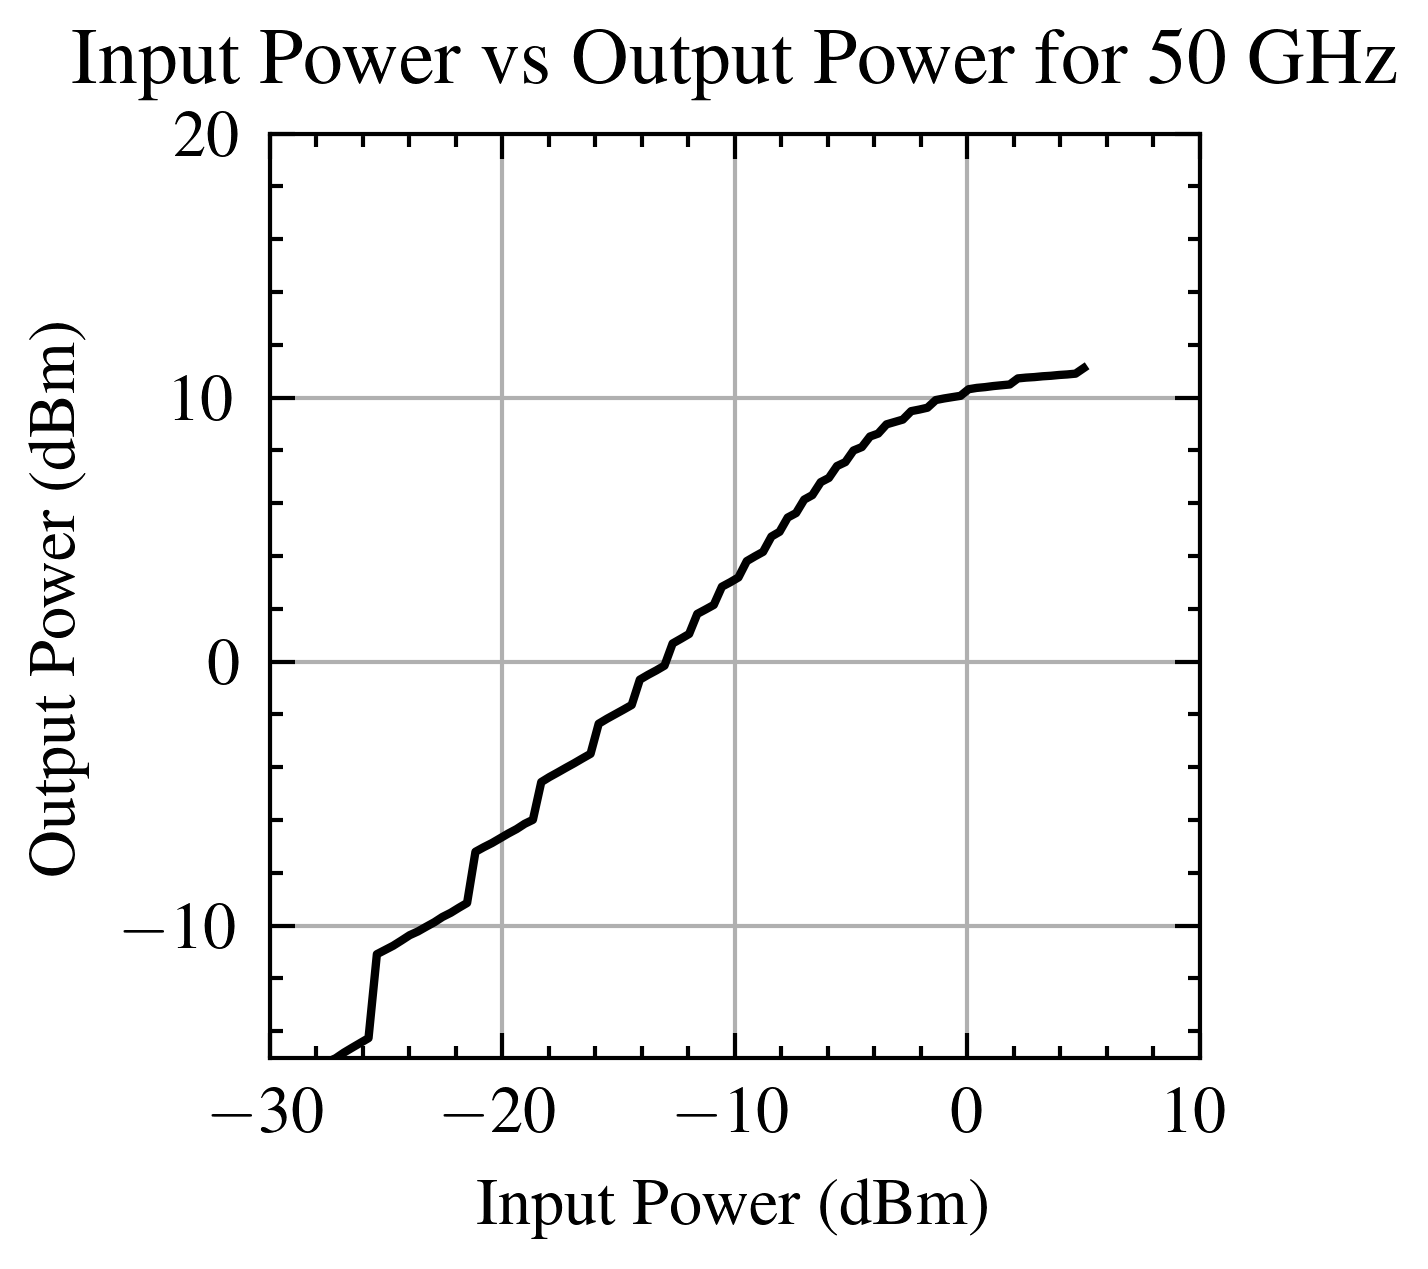

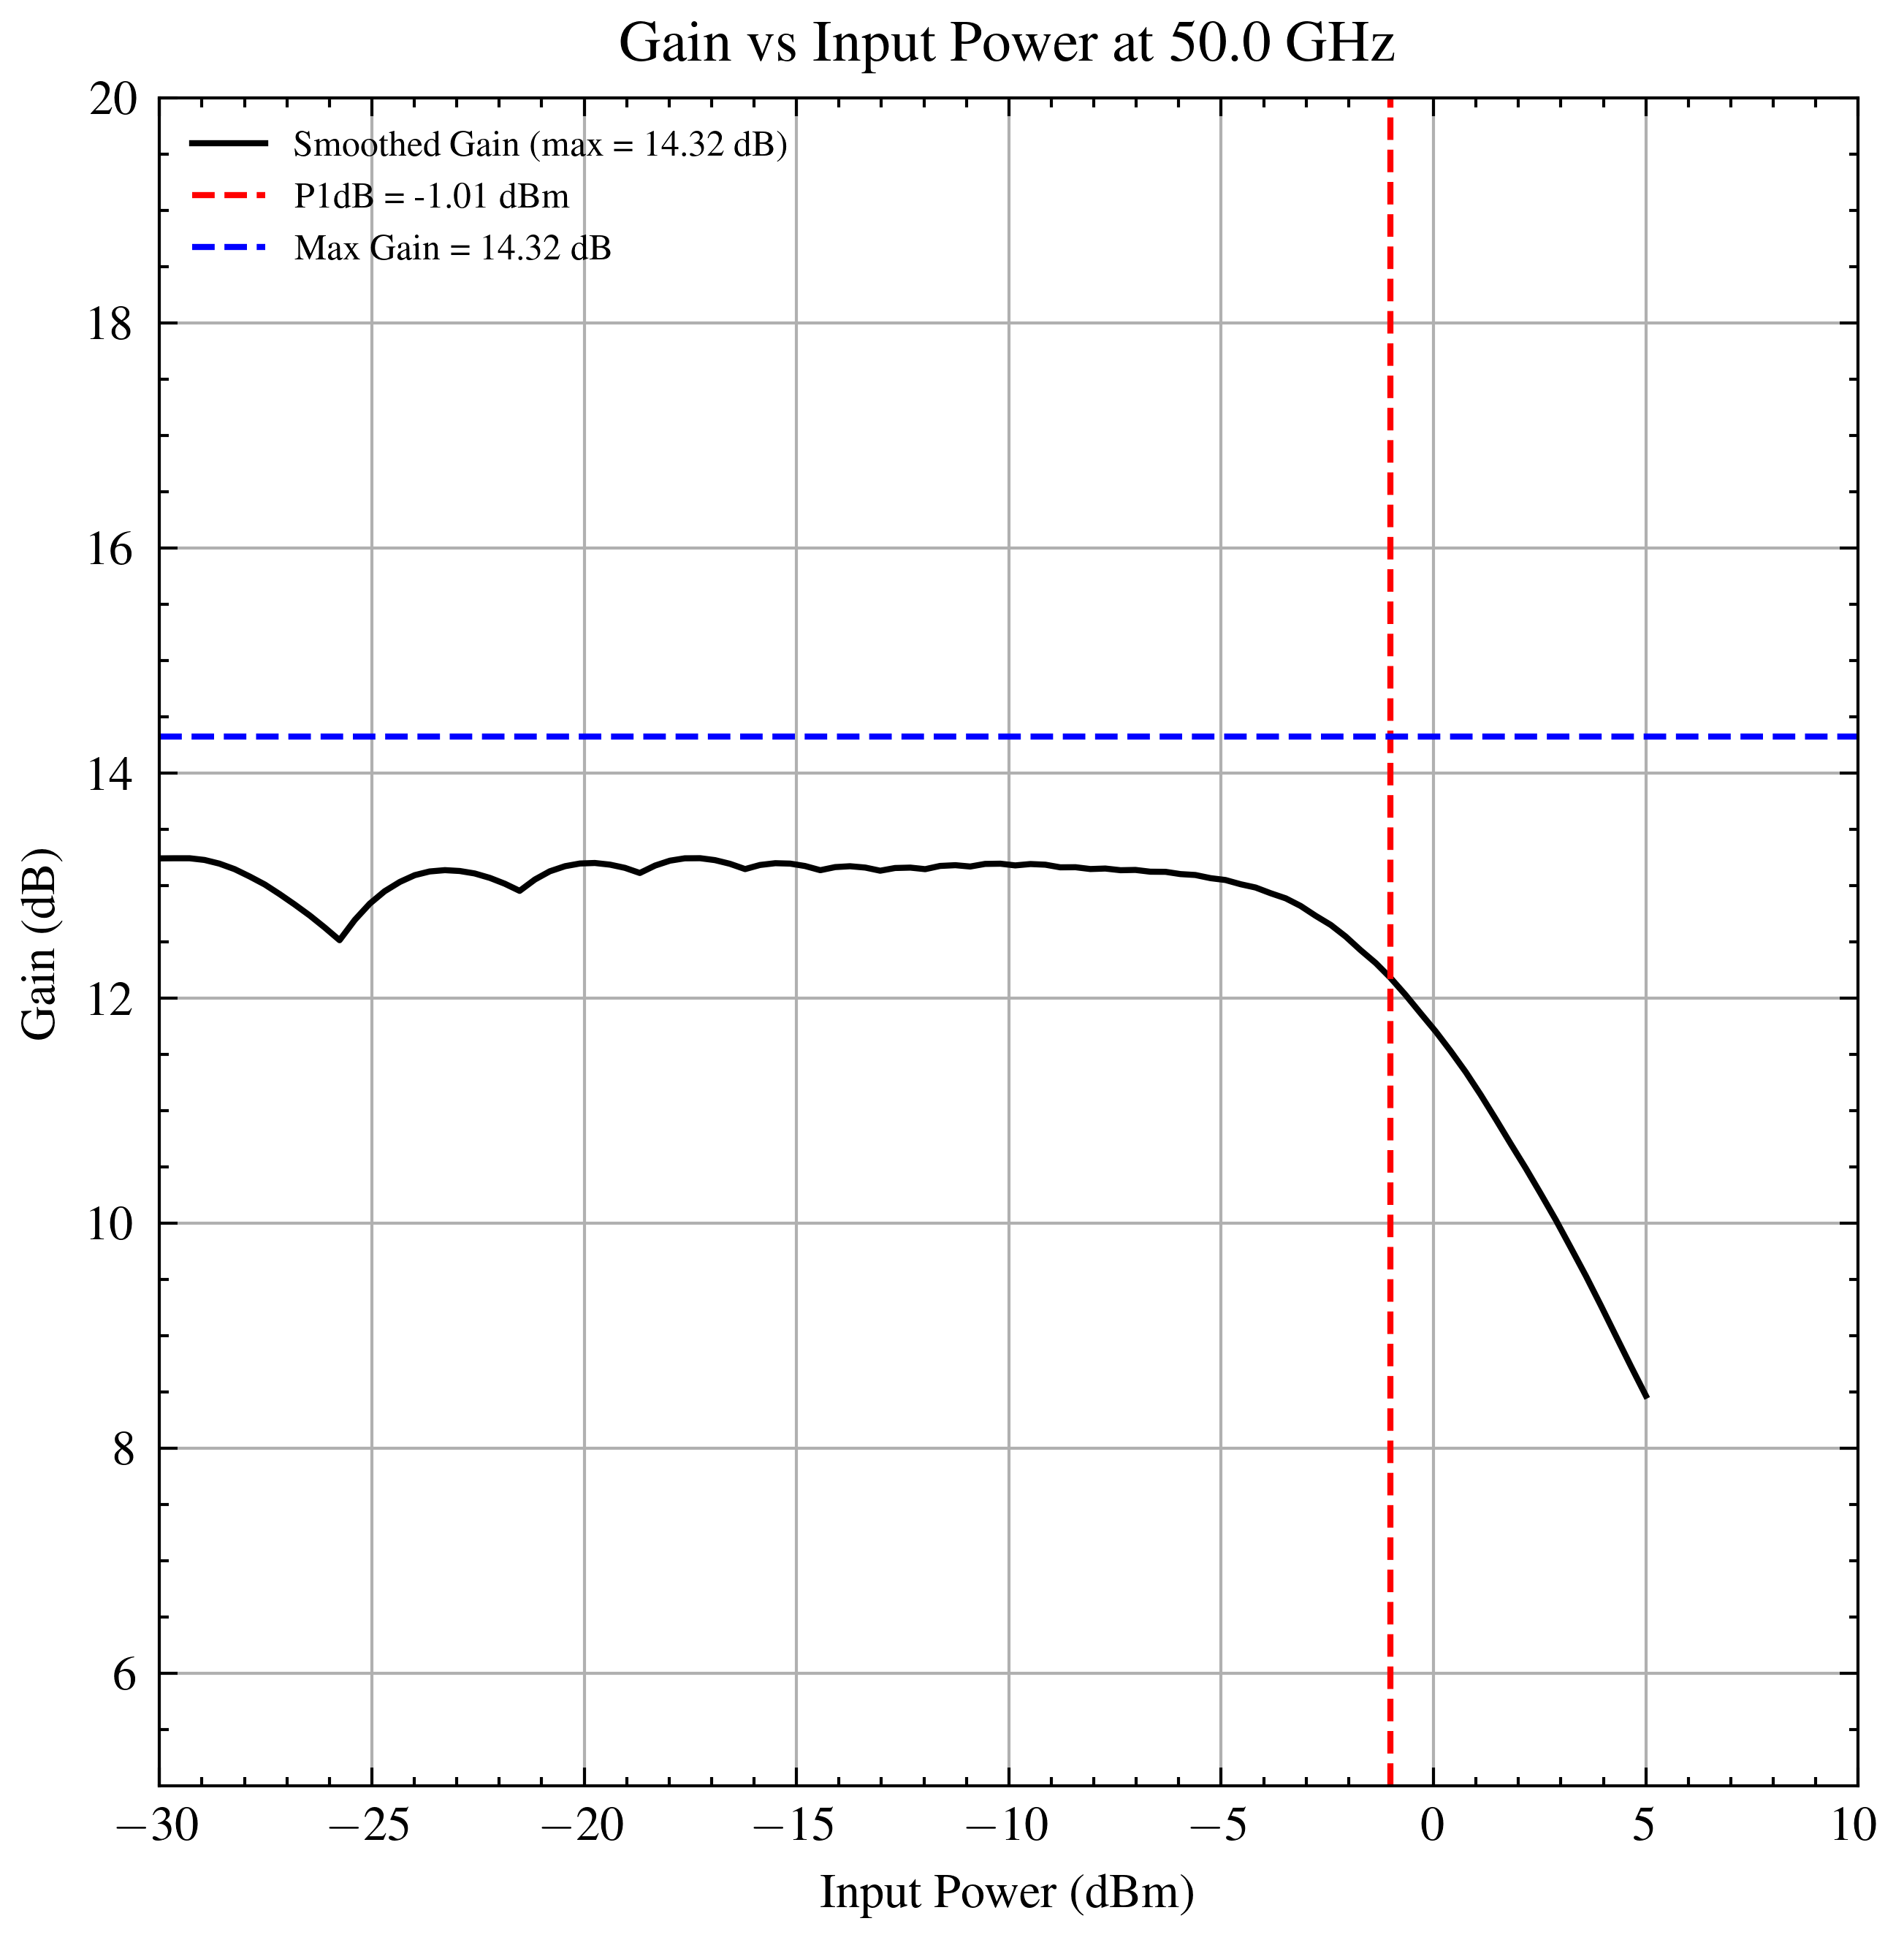

In [110]:
def exponential_moving_average(data, alpha=0.1):
    ema = [data[0]]  # Start with the first value
    for point in data[1:]:
        ema.append(alpha * point + (1 - alpha) * ema[-1])
    return np.array(ema)

# Apply exponential moving average
smoothed_gain = exponential_moving_average(Gain_db, alpha=0.1)

# Calculate P1dB (abs max gain - smoothed gain - 1 dB)
p1db = abs(np.max(smoothed_gain) - smoothed_gain - 1)

# Find the index where P1dB occurs
p1db_index = np.argmin(p1db)
Pi_p1db = input_power[p1db_index]  # Input power at P1dB

# Plot the smoothed data
plt.figure(figsize=(5, 5))
plt.plot(input_power, smoothed_gain, label=f'Smoothed Gain (max = {max_gain_db:.2f} dB)')
plt.axvline(x=Pi_p1db, color='red', linestyle='--', label=f'P1dB = {Pi_p1db:.2f} dBm')
plt.axhline(y=max_gain_db, color='blue', linestyle='--', label=f'Max Gain = {max_gain_db:.2f} dB')

# Plot the labels and the title
plt.xlabel("Input Power (dBm)")
plt.ylabel("Gain (dB)")
plt.title(f"Gain vs Input Power at {50e9/1e9} GHz")

# Set axis limits and show the legend
plt.xlim(-30, 10)
plt.ylim(5, 20)
plt.legend(fontsize=6)

# Show grid and plot
plt.grid()
plt.show()